# Libraries and Data

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
import skopt
import warnings
import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [275]:
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [276]:
train = pd.read_csv("../data/advanced_train.csv", low_memory = False)
test = pd.read_csv("../data/advanced_test.csv", low_memory = False)
sample = pd.read_csv("../data/sample_submission.csv", low_memory = False)

In [48]:
train.shape, test.shape

((37439, 40), (10000, 39))

In [49]:
train.columns, test.columns

(Index(['Id', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating',
        'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region', 'Elementary School', 'Elementary School Score',
        'Elementary School Distance', 'Middle School', 'Middle School Score',
        'Middle School Distance', 'High School', 'High School Score',
        'High School Distance', 'Flooring', 'Heating features',
        'Cooling features', 'Appliances included', 'Laundry features',
        'Parking features', 'Tax assessed value', 'Annual tax amount',
        'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
        'Zip', 'State'],
       dtype='object'),
 Index(['Id', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking',
        'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spaces',
        'Region',

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37439 entries, 0 to 37438
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           37439 non-null  int64  
 1   Sold Price                   37439 non-null  int64  
 2   Summary                      37176 non-null  object 
 3   Type                         37439 non-null  object 
 4   Year built                   36686 non-null  float64
 5   Heating                      32481 non-null  object 
 6   Cooling                      29109 non-null  object 
 7   Parking                      36720 non-null  object 
 8   Lot                          26041 non-null  float64
 9   Bedrooms                     35235 non-null  object 
 10  Bathrooms                    34786 non-null  float64
 11  Full bathrooms               31696 non-null  float64
 12  Total interior livable area  35443 non-null  float64
 13  Total spaces    

# Data Exploration

## Training Data Cleansing

### Prices
Manual adjustments to list price to make the data more reasonable

## School

In [53]:
#sns.histplot(np.log(train["Sold Price"]))
#sns.histplot(train["Garage spaces"])
#train["Year built"].unique()
train["High School Distance"].isna().any()

True

In [54]:
train["Elementary School Distance"]

0        0.8
1        0.3
2        0.6
3        0.2
4        0.3
        ... 
37434    0.3
37435    0.2
37436    NaN
37437    0.5
37438    1.5
Name: Elementary School Distance, Length: 37439, dtype: float64

<AxesSubplot:>

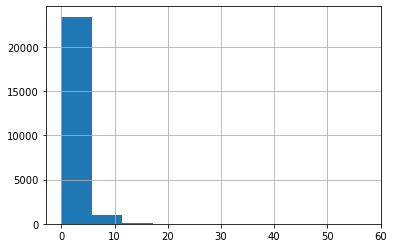

In [55]:
train["Middle School Distance"].hist()

<AxesSubplot:>

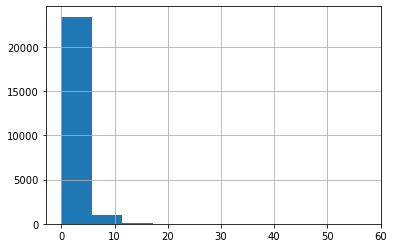

In [56]:
train["Middle School Distance"].hist()

## Heating

In [57]:
asdf = train["Heating"].value_counts()
asdf

Central                                            7280
Central Forced Air                                 4695
Central Forced Air - Gas                           3041
Forced Air                                         1977
Wall Furnace                                       1535
                                                   ... 
Stove - Wood, Other                                   1
Radiant, Daiken Mini Splits                           1
Solar, Central Forced Air - Gas, Radiant Floors       1
Propane, Electric, Wall Furnace, Wood Stove           1
Natural Gas, Electric                                 1
Name: Heating, Length: 1536, dtype: int64

In [58]:
heat_types = train["Heating"].str.lower().str.split(",").explode().str.strip().value_counts()
heat_types.head(30)
# h1 = central, forced air, forced, furnace
# h2 = radiant, heat pump, baseboard, steam, zone
# h3 = wood, stove, fireplace, fire, coal, pellet
# h4 = solar, geothermal

central                     9195
forced air                  5999
central forced air          5830
central forced air - gas    3969
gas                         3522
wall furnace                2150
other                       1667
electric                    1438
fireplace                    928
baseboard                    699
natural gas                  678
radiant                      671
heating - 2+ zones           652
propane                      631
fireplace(s)                 469
none                         453
wall                         424
floor furnace                422
heat pump                    365
wood stove                   339
solar                        284
propane / butane             230
radiant floors               219
zoned                        201
stove                        177
wood / pellet                172
stove - wood                 138
forced air - gas             120
see remarks                  117
individual room controls     102
Name: Heat

In [59]:
train["Heating features"].str.lower().str.split(",").explode().str.replace(" ", "").value_counts().shape

(60,)

## Parking

In [60]:
# Take a looka at the most common values in the parking variable.
# 156 unique values in the parking variable
parking_types_train = train["Parking"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()

parking_types_train.head(40)
parking_types_train.index


Index(['garage', 'covered', 'garage-attached', 'driveway', 'carport',
       'garagedooropener', '0spaces', 'sidebyside', 'attached',
       'garage-detached',
       ...
       'over20spaces', 'drivethrugarage', 'uncoveredparkspaces2+',
       'morethanonespace', 'rvparking', 'unc#3', 'detachedgarage',
       'uncoveredparkingspace', 'carports-2ormore', 'sinkingarage'],
      dtype='object', length=156)

In [61]:

for ptype in parking_types_train.index:
    print(ptype)
    train[ptype] = train["Parking"].str.lower().str.replace(" ", "").str.contains(ptype)
    

garage
covered
garage-attached
driveway
carport
garagedooropener
0spaces
sidebyside
attached
garage-detached
garage-twodoor
off-street
onsite(singlefamilyonly)
interioraccess
independent
assigned
onsite
concrete
communitystructure
tandem
gated
on-street
guest
garage-singledoor
enclosed
underground/basement
private
none
controlledentrance
directaccess
detachedcarport
onsite-mapped(condoonly)
onstreet
garagefacesfront
offstreet
underground
open
autodrivewaygate
parkingspace
attachedcarport
detached
garage-threedoor
rvaccess/parking
valet
mixed
paved
shareddriveway
oversized
circulardriveway
drivewaylevel
built-instorage
convertedgarage
gravel
boat
driveway-combination
rvpotential
other
onsite-unassigned(condoonly)
rv
oversizedparking
workshopingarage
garagefacesrear
nogarage
garagefacesside
2cargarage
drivewaydownslopefromstreet
intaccessfromgarage
drivewayupslopefromstreet
mechanicallift
seeremarks
potentialrvparking
tandemcovered
sideyardaccess
asphalt
autoopener
sizelimited
rv/boatpar

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


offsite
tandemuncovered
public
golfcartgarage
additionalcarport
pull-through
utilitysink
rvcovered
structure
rotational
additionalgarage
nodriveway
secured
gar#1
electricvehiclechargingstation(s)
overheightgarage
insideentrance
drivethru
unc#2
gar#3
guestspace(s)
noparkingonsite
two
notassigned
drivethrough
3cargarage
1cargarage
3ormoreparkingsp
2parkingspaces
rvpossible
4+cargarage
offstreetparking
remote
heatedgarage
cpt#1
insulated
streetparking
gar#4
one
1-10spaces
undersizedgarage
rvaccess
manualdoor
cpt#2
over20spaces
drivethrugarage
uncoveredparkspaces2+
morethanonespace
rvparking
unc#3
detachedgarage
uncoveredparkingspace
carports-2ormore
sinkingarage


## Lot

In [277]:
np.min(train["Lot"])

0.0

<AxesSubplot:>

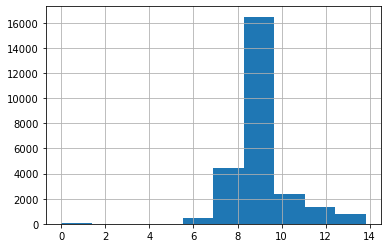

In [62]:
np.log(np.minimum(train["Lot"], 1e6) + 1).hist()

In [63]:
train[train["Lot"].isna()]

,Id,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,...,over20spaces,drivethrugarage,uncoveredparkspaces2+,morethanonespace,rvparking,unc#3,detachedgarage,uncoveredparkingspace,carports-2ormore,sinkingarage
1,1,711000,"Modern, Hip, & Bright! This beautifully mainta...",Condo,2016.0,Central,"Air Conditioning, Central",Covered,NaN,2,...,False,False,False,False,False,False,False,False,False,False
5,5,196000,HUD Home Opportunity. This 2 Bedroom/ 2 Bath h...,VacantLand,1973.0,Other,Central,"Garage - Attached, Covered",NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
9,9,432000,Live in the heart of West Hollywood at one of ...,Condo,1973.0,Central,Central Air,0 spaces,NaN,0,...,False,False,False,False,False,False,False,False,False,False
12,12,686000,GREAT LOCATION - Near USC and L A Coliseum. 2...,Unknown,1906.0,NaN,NaN,Garage,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
14,14,326000,"Smartsville, CA ~ Commute? No problem! This ho...",MobileManufactured,2005.0,Central,"Central Air, Ceiling Fan(s)",Off-street,NaN,3,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37418,37418,427000,"Gated Complex W/ Large Common Courtyard Area, ...",Condo,1982.0,Central,Whole House Fan,Garage,NaN,2,...,False,False,False,False,False,False,False,False,False,False
37423,37423,687000,Prime Location in LA. Center of Mid-Wilshire. ...,Condo,2007.0,Central,Central Air,Garage - Two Door,NaN,3,...,False,False,False,False,False,False,False,False,False,False
37424,37424,808000,"In the heart of the city, this two-bedroom con...",Condo,1963.0,Electric,NaN,"Attached, Enclosed, Garage Door Opener, Interi...",NaN,2,...,False,False,False,False,False,False,False,False,False,False
37430,37430,942000,Great Investment Opportunity!!!! Four Unit El ...,MultiFamily,1940.0,Wall,NaN,Covered,NaN,8,...,False,False,False,False,False,False,False,False,False,False


In [64]:
train["Type"].str.lower().str.replace(" ", "").unique()
# singlefamily
# condo, duplex, triplex, multifamily
# new
# apartment
# luxury, penthouse, rise
# vacant

array(['singlefamily', 'condo', 'townhouse', 'vacantland', 'unknown',
       'mobilemanufactured', 'multifamily', 'cooperative',
       'topfloor,2level', 'apartment', '3story', '4+story',
       '2story,duplex', 'detached,splitlevel', 'duplex',
       'luxury,townhouse,2level',
       'mid-rise(4-8),unitbelow,unitabove,3level',
       'topfloor,2level,low-rise(1-3)', 'detached',
       'topfloor,flat,low-rise(1-3)', 'acreage', 'flat,attached',
       'topfloor,flat,full,unitabove,penthouse', 'mid-rise(4-8),endunit',
       '1level,flat,low-rise(1-3),unitabove', 'mid-rise(4-8)',
       'topfloor,2level,semi-attached', 'residentiallot', 'ranch',
       'luxury,2level', 'mfd-f', 'luxury,mid-rise(4-8)',
       '2story,full,attached', '2level,detached', '3level,live/work',
       'full,semi-attached', 'newconstruction,low-rise(1-3)',
       'hi-rise(9+)', 'triplex', '2story', 'residential',
       'low-rise(1-3),full,unitabove', 'mid-rise(4-8),topfloor,unitbelow',
       'doublewide', 'uni

In [65]:
train["Type"].str.lower().str.replace(" ", "").value_counts().head(50)

singlefamily                            24635
condo                                    6630
townhouse                                2040
unknown                                  1291
multifamily                               987
mobilemanufactured                        801
vacantland                                606
apartment                                 149
cooperative                                34
mfd-f                                      20
residentiallot                             16
2story                                     15
acreage                                    12
duplex                                     11
3story                                      9
manufacturedhome                            7
3story,duplex                               7
31                                          7
mid-rise(4-8)                               6
topfloor                                    6
hi-rise(9+)                                 6
detached,2story                   

In [66]:
train.median()["Sold Price"]

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


1042000.0

Impute missing values for certain numeric variables

## Last Sold

In [67]:
train["Last Sold On"].fillna("1/1/2021")

0        12/28/2018
1          1/1/2021
2          1/1/2021
3          1/1/2021
4          1/1/2021
            ...    
37434    12/28/2012
37435     4/30/1999
37436     9/16/1998
37437      1/1/2021
37438      8/7/2003
Name: Last Sold On, Length: 37439, dtype: object

In [68]:
asdf = (pd.to_datetime("1/1/2021") - pd.to_datetime(train["Last Sold On"].fillna("1/1/2021"))).dt.days
asdf

0         735
1           0
2           0
3           0
4           0
         ... 
37434    2926
37435    7917
37436    8143
37437       0
37438    6357
Name: Last Sold On, Length: 37439, dtype: int64

In [69]:
np.min(pd.to_datetime("1/1/2021") - pd.to_datetime(asdf))

Timedelta('18627 days 23:59:59.999982645')

## Flooring

In [70]:
train["Flooring"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts().head(40)

tile                      13522
carpet                    11949
wood                       9414
hardwood                   8556
laminate                   6338
vinyl/linoleum             1862
linoleum/vinyl             1052
stone                       774
other                       770
vinyl                       769
marble                      478
concrete                    405
ceramictile                 272
travertine                  237
linoleum                    232
slate                       219
bamboo                      212
simulatedwood               204
seeremarks                  110
parquet                      74
carpeted                     73
granite                      71
engineeredwood               64
mixed                        62
hardwoodflrsthroughout       61
other-rmks                   42
mexicantile                  33
softwood                     32
cement                       19
brick                        17
cork                         12
naturals

## Bedrooms

In [71]:
train["Bedrooms"].unique()

array(['5', '2', '4', 'Walk-in Closet', nan,
       'Ground Floor Bedroom, Master Bedroom on Ground Floor, More than One Bedroom on Ground Floor',
       '3',
       'Ground Floor Bedroom, Master Suite / Retreat, More than One Bedroom on Ground Floor, Walk-in Closet',
       '0',
       'Ground Floor Bedroom, Master Bedroom on Ground Floor, More than One Bedroom on Ground Floor, Walk-in Closet',
       '1', 'Walk-in Closet, Master Suite / Retreate - 2+',
       'Ground Floor Bedroom, Walk-in Closet, More than One Master Bedroom on Ground Floor',
       '6', 'Loft Bedroom', 'Master Bedroom on Ground Floor',
       'Master Suite / Retreat',
       'Ground Floor Bedroom, Master Suite / Retreat',
       'Master Bedroom on Ground Floor, Master Suite / Retreat',
       'Master Suite / Retreat, Walk-in Closet',
       'More than One Bedroom on Ground Floor, Master Suite / Retreate - 2+, More than One Master Bedroom on Ground Floor',
       '7',
       'Ground Floor Bedroom, Walk-in Closet, Ma

## Tax Value

In [72]:
train.replace('#DIV/0!', np.NaN)[~train["Tax assessed value"].isna()]["Tax assessed value"].astype('float').median()

599767.0

In [73]:
train["Tax assessed value"].replace('#DIV/0!', np.NaN).astype('float').fillna(0)

0         349821.0
1              0.0
2        1718863.0
3         997908.0
4          77854.0
           ...    
37434    1807714.0
37435     394375.0
37436     596851.0
37437     188119.0
37438    1044984.0
Name: Tax assessed value, Length: 37439, dtype: float64

## Appliances

In [74]:
train["Appliances included"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts().head(20)

dishwasher          21144
refrigerator        16867
microwave           12971
washer              12490
dryer               12102
range/oven          10990
garbagedisposal      9734
disposal             6048
freezer              2484
rangehood            2119
gasrange             1185
trashcompactor       1098
gaswaterheater        918
gasoven               756
gascooktop            713
oven                  630
range                 546
doubleoven            470
selfcleaningoven      458
barbecue              423
Name: Appliances included, dtype: int64

## List Date

<AxesSubplot:>

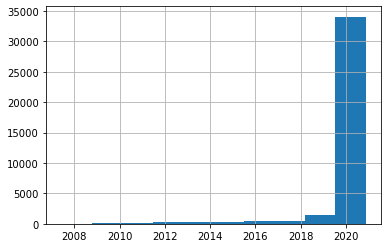

In [75]:
pd.to_datetime(train["Listed On"]).hist()

In [76]:
pd.to_datetime(train["Listed On"]).dt.year + pd.to_datetime(train["Listed On"]).dt.month/12

0        2020.583333
1        2020.500000
2        2020.750000
3        2020.500000
4        2020.333333
            ...     
37434    2020.333333
37435    2020.333333
37436    2020.333333
37437    2020.166667
37438    2020.083333
Name: Listed On, Length: 37439, dtype: float64

## City

In [77]:
train["City"].value_counts().head(20)

Los Angeles       8799
San Jose          5666
San Francisco     4202
San Mateo          898
Santa Clara        896
Santa Cruz         708
Sunnyvale          691
Los Gatos          563
Morgan Hill        495
Redwood City       481
Gilroy             451
Compton            449
Mountain View      438
Palo Alto          425
Milpitas           400
Aptos              393
Los Altos          382
Culver City        349
West Hollywood     333
Watsonville        330
Name: City, dtype: int64

## Region

In [78]:
# basically the same as city so not using it
train["Region"].value_counts().head(20)

Los Angeles       8860
San Jose          5863
San Francisco     4201
San Mateo          720
Santa Clara        703
Santa Cruz         700
Sunnyvale          691
Los Gatos          522
Morgan Hill        495
Gilroy             450
Compton            441
Mountain View      438
Milpitas           400
Aptos              393
Redwood City       377
Palo Alto          361
West Hollywood     346
San Carlos         313
Culver City        302
Menlo Park         298
Name: Region, dtype: int64

## Type

In [272]:
train["Type"].str.lower().str.replace(" ", "").value_counts().head(20)

singlefamily          24635
condo                  6630
townhouse              2040
unknown                1291
multifamily             987
mobilemanufactured      801
vacantland              606
apartment               149
cooperative              34
mfd-f                    20
residentiallot           16
2story                   15
acreage                  12
duplex                   11
3story                    9
manufacturedhome          7
3story,duplex             7
31                        7
mid-rise(4-8)             6
topfloor                  6
Name: Type, dtype: int64

# Data Pre-Processing

In [338]:
# Reread data to ensure we're using accurate data
train = pd.read_csv("../data/advanced_train.csv", low_memory = False)
test = pd.read_csv("../data/advanced_test.csv", low_memory = False)

# Manual adjustments to prices to remove outliers
train["Last Sold Price"] = np.where((train["Last Sold Price"] / train["Sold Price"] > 10) |
                                     (train["Last Sold Price"] / train["Sold Price"] < 0.1),
                                     0,
                                     train["Last Sold Price"])
train["Listed Price"] = np.where((train["Listed Price"] / train["Sold Price"] > 10) |
                                  (train["Listed Price"] / train["Sold Price"] < 0.1),
                                 0,
                                 train["Listed Price"])

In [339]:
#imp = IterativeImputer()
imp = KNNImputer(n_neighbors = 10)

imp_vars = ["Total interior livable area", "Full bathrooms", "Bathrooms",
           "Total spaces", "Elementary School Score", "Elementary School Distance", 
           "Middle School Score", "Middle School Distance", "High School Score",
           "High School Distance", "Year built", "Garage spaces"] # , "Lot"

In [340]:
imp.fit(train[imp_vars])

KNNImputer(n_neighbors=10)

In [341]:
parking_types_train = train["Parking"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
heating_types_train = train["Heating"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
flooring_types_train = train["Flooring"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
appliance_types_train = train["Appliances included"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
cities_train = train["City"].value_counts().head(200)
types_train = train["Type"].str.lower().str.replace(" ", "").value_counts().head(20)


train_medians = train.median()
test_medians = test.median()

def preprocess_data(df, imp, imp_v, meds, ptypes_train, htypes_train, ftypes_train, atypes_train, cities, ttypes_train):
    
    df[imp_v] = imp.transform(df[imp_v]) 
    
    df["Total interior livable area"] = df["Total interior livable area"].fillna(meds["Total interior livable area"])
    
    df["Bathrooms"] = df["Bathrooms"].fillna(meds["Bathrooms"])
    
    df["Total spaces"] = df["Total spaces"].fillna(meds["Total spaces"])
    df["Total spaces"] = np.abs(np.minimum(df["Total spaces"], 30))
    
    df["Elementary School Score"] = df["Elementary School Score"].fillna(meds["Elementary School Score"])
    df["Elementry School Distance"] = df["Elementary School Distance"].fillna(meds["Elementary School Distance"])
    
    df["Middle School Score"] = df["Middle School Score"].fillna(meds["Middle School Score"])
    df["Middle School Distance"] = df["Middle School Distance"].fillna(meds["Middle School Distance"])

    df["High School Score"] = df["High School Score"].fillna(meds["High School Score"])
    df["High School Distance"] = df["High School Distance"].fillna(meds["High School Distance"])
    
    df["Year built"] = df["Year built"].fillna(meds["Year built"])
    df["Year built"] = np.maximum(df["Year built"], 1870)
    df["Year built"] = np.minimum(df["Year built"], 2022)
    
    df["state_ind"] = df["State"] == "CA"
    
    df["Garage spaces"] = df["Garage spaces"].fillna(meds["Garage spaces"])
    df["Garage spaces"] = np.maximum(df["Garage spaces"], 0)
    df["Garage spaces"] = np.minimum(df["Garage spaces"], 20)
    
    
    df["Full bathrooms"] = df["Full bathrooms"].fillna(meds["Full bathrooms"])

    # Doesn't seem to matter which impute strategy I use
    #df["l1"] = df["Lot"].fillna(meds["Lot"])
    df["l1"] = df["Lot"].fillna(0)
    
    df["Last Sold Price"] = df["Last Sold Price"].fillna(0)
    df["Last Sold Days"] = (pd.to_datetime("1/1/2021") - pd.to_datetime(df["Last Sold On"].fillna("1/1/2021"))).dt.days
    
    df["Tax assessed value"] = df["Tax assessed value"].replace('#DIV/0!', np.NaN).astype('float').fillna(0)
    
    df["Listed On"] = pd.to_datetime(df["Listed On"]).dt.year + (pd.to_datetime(df["Listed On"]).dt.month/12)
    
    for htype in htypes_train.index:
        df[("h_" + htype)] = df["Heating"].str.lower().str.replace(" ", "").str.contains(htype, na=False)
    
    for ptype in ptypes_train.index:
        df[("p_" + ptype)] = df["Parking"].str.lower().str.replace(" ", "").str.contains(ptype, na=False)
    
    for ftype in ftypes_train.index:
        df[("f_" + ftype)] = df["Flooring"].str.lower().str.replace(" ", "").str.contains(ftype, na=False)

    for atype in atypes_train.index:
        df[("a_" + atype)] = df["Appliances included"].str.lower().str.replace(" ", "").str.contains(atype, na=False)

    for city in cities.index:
        df[city] = df["City"].str.contains(city, na=False)
        
    for ttype in ttypes_train.index:
        df[("t_" + ttype)] = df["Type"].str.lower().str.replace(" ", "").str.contains(ttype, na=False)
    
        
    df["r1"] = df["Listed Price"] / (df["Last Sold Price"] + 0.1)
    df["r2"] = df["Last Sold Price"] / (df["Tax assessed value"] + 0.1)
    df["r3"] = df["Tax assessed value"] / (df["Listed Price"] + 0.1)
    
    return df

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':
/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


In [342]:
train_p = preprocess_data(train, imp, imp_vars, train_medians, parking_types_train, 
                          heating_types_train, flooring_types_train, 
                          appliance_types_train, cities_train, types_train)


/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

Determine the target

In [343]:
#y = np.log(train["Sold Price"])
y = train["Sold Price"]

In [344]:
# Get this feature importance from training a model below with max_features = None. 
# Then use the top X features in a model with max_features = 'sqrt'
#feat_imp_orig = feat_importances

In [345]:
pred_vars = ["Listed Price", "Total interior livable area", "Bathrooms", 
             "Year built", "High School Score", "Garage spaces", "state_ind", 
            "Elementary School Score", "Full bathrooms",
            "Total spaces", "High School Distance", 
            "l1", "Last Sold Price", "Last Sold Days", "Tax assessed value", "Listed On", 
            "r1", "r2", "r3"] + list("p_" + parking_types_train.index) + list("h_" + heating_types_train.index) + list("f_" + flooring_types_train.index) + list("a_" + appliance_types_train.index) + list(cities_train.index) + list("t_" + types_train.index)

#pred_vars = list(feat_imp_orig.nlargest(100).index)
# Used top 70/300
# Used top 80/360

X = train_p[pred_vars]

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 56)

# Models

In [383]:
params = {"n_estimators":700,
          "learning_rate":0.15,
          "max_depth":3,
          "random_state":56,
          "subsample":1,
          'max_features':None, # None or sqrt
          "loss":'squared_error'}

In [378]:
model = GradientBoostingRegressor(verbose = 1).set_params(**params)

In [379]:
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1 2284461932656.8145            3.42m
         2 1909266497860.4353            3.45m
         3 1597750496693.2390            3.51m
         4 1343225516574.8862            3.48m
         5 1135772199014.8796            3.47m
         6 964807175809.9008            3.54m
         7 823707033969.0685            3.53m
         8 709043667324.0385            3.52m
         9 613738899640.3616            3.53m
        10 534613053508.4905            3.51m
        20 206030294510.7999            3.42m
        30 139759011157.9620            3.36m
        40 118058997691.9036            3.31m
        50 103377968183.5244            3.26m
        60 91480723638.8006            3.21m
        70 84581350409.3892            3.18m
        80 79815484117.0296            3.14m
        90 76212613733.8397            3.10m
       100 72342013745.2276            3.07m
       200 53388340555.6057            2.72m
       300 44805215997.2768        

GradientBoostingRegressor(n_estimators=1000, random_state=56, subsample=1,
                          verbose=1)

In [380]:
model.score(X_test, y_test)

# 0.8979036811661909

0.891205623072691

<AxesSubplot:>

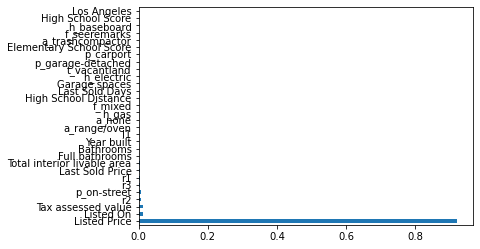

In [381]:
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
feat_importances.nlargest(30).plot(kind='barh')

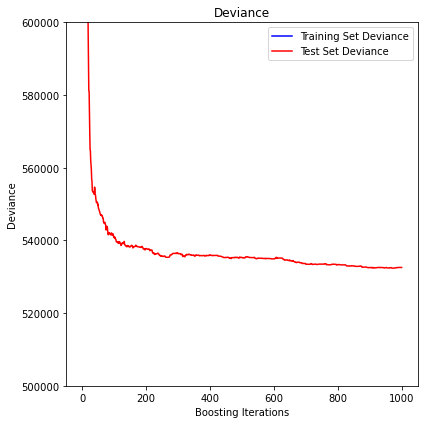

532363.3891129794


In [382]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    #test_score[i] = model.loss_(y_test, y_pred)   # This is just squared error
    test_score[i] = np.sqrt(((y_pred - y_test) ** 2).mean())  # this is RMSE

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1, model.train_score_,
    "b-", label="Training Set Deviance",
)
plt.plot(np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
#plt.ylim(0.03, 0.06)
plt.ylim(5e5, 6e5)
fig.tight_layout()
plt.show()
print(np.min(test_score))

# 515801.10557718197

# Error Investigation
Looking into train examples where the error is really high

In [173]:
errs = y_pred - y_test

In [94]:
erratio = y_pred / y_test

In [95]:
erratio.nlargest(20)

18924    20.592032
2381     12.987054
24033    12.087758
11211     9.111648
1297      8.764293
11533     7.897932
6452      7.879156
3014      7.658462
32682     6.889345
15292     6.322995
33480     6.052440
16999     6.052246
19848     5.991249
9857      5.989314
7251      5.966262
31140     5.964438
24706     5.839968
37149     5.815545
13039     5.724097
8117      5.699650
Name: Sold Price, dtype: float64

In [96]:
X_test[errs > 1e6].join(train["Sold Price"])[["Listed Price", "Sold Price", "Last Sold Price", "Last Sold Days"]]



,Listed Price,Sold Price,Last Sold Price,Last Sold Days
2381,0,133000,0.0,773
18924,287000,190000,550000.0,1379
11533,16094000,1726000,0.0,0
31772,7064000,6082000,5300000.0,2051
2941,5176888,3344000,0.0,0
...,...,...,...,...
27856,17592000,14321000,15600000.0,966
23596,18898000,10455000,0.0,0
33480,1601000,293000,1560000.0,1912
12333,1474000,366000,1733000.0,928


In [97]:
train.iloc[4099].head(50)

Id                                                                          4099
Sold Price                                                                115500
Summary                        3030 Flores St, San Mateo, CA 94403 is a singl...
Type                                                                SingleFamily
Year built                                                                2000.0
Heating                                                    Forced air, Wall, Gas
Cooling                                                                     None
Parking                                       Garage, Garage - Attached, Covered
Lot                                                                       7919.0
Bedrooms                                                                       5
Bathrooms                                                                    6.0
Full bathrooms                                                               2.4
Total interior livable area 

# Hyperparameter Optimization

In [98]:
BayesSearchCV?

In [376]:
opt = BayesSearchCV(
    GradientBoostingRegressor(random_state = 56,loss = 'squared_error'),
    {
        'n_estimators': (25, 250),
        'learning_rate': (.01, .5, 'log-uniform'),
        'max_depth': (2, 6),  # integer valued parameter
    },
    n_iter = 30,
    cv = 3,
    verbose = 1
)

In [377]:
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=56),
              n_iter=30,
              search_spaces={'learning_rate': (0.01, 0.5, 'log-uniform'),
                             'max_depth': (2, 6), 'n_estimators': (25, 250)},
              verbose=1)

In [378]:
opt.score(X_test, y_test)

# 0.930401 with no subsampling
# 0.929161025403613 with subsampling, 50 iterations


0.8861050552210015

In [380]:
opt.best_estimator_.max_depth, opt.best_estimator_.learning_rate, opt.best_estimator_.n_estimators, opt.best_estimator_.subsample

# (4, 0.019076781177538346, 500, 1.0) with no subsampling
# (5, 0.011876032175591269, 376, 0.44775503528274996) with subsampling (50 iterations)


(4, 0.07311285746741947, 91, 1.0)

In [38]:
params["max_depth"] = opt.best_estimator_.max_depth
params["learning_rate"] = opt.best_estimator_.learning_rate
params["n_estimators"] = opt.best_estimator_.n_estimators
params["subsample"] = opt.best_estimator_.subsample

# Train final model
Use all the data

In [384]:
print(params)
print(pred_vars), len(pred_vars)

{'n_estimators': 700, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 56, 'subsample': 1, 'max_features': None, 'loss': 'squared_error'}
['Listed Price', 'Total interior livable area', 'Bathrooms', 'Year built', 'High School Score', 'Garage spaces', 'state_ind', 'Elementary School Score', 'Full bathrooms', 'Total spaces', 'High School Distance', 'l1', 'Last Sold Price', 'Last Sold Days', 'Tax assessed value', 'Listed On', 'r1', 'r2', 'r3', 'p_garage', 'p_covered', 'p_garage-attached', 'p_driveway', 'p_carport', 'p_garagedooropener', 'p_0spaces', 'p_sidebyside', 'p_attached', 'p_garage-detached', 'p_garage-twodoor', 'p_off-street', 'p_onsite(singlefamilyonly)', 'p_interioraccess', 'p_independent', 'p_assigned', 'p_onsite', 'p_concrete', 'p_communitystructure', 'p_tandem', 'p_gated', 'p_on-street', 'p_guest', 'p_garage-singledoor', 'p_enclosed', 'p_underground/basement', 'p_private', 'p_none', 'p_controlledentrance', 'p_directaccess', 'p_detachedcarport', 'p_onsite-mapped(condoonl

(None, 660)

In [385]:
model = GradientBoostingRegressor(verbose = 1).set_params(**params).fit(X, y)

      Iter       Train Loss   Remaining Time 
         1 2053462698114.2832            4.07m
         2 1570811111035.6648            4.08m
         3 1220970000448.0796            4.09m
         4 959530134722.5613            4.09m
         5 765610177039.7645            4.04m
         6 620153144696.4231            4.01m
         7 512775310793.3365            4.00m
         8 431106123123.9572            4.00m
         9 370326628588.7768            3.98m
        10 323811015251.4847            3.97m
        20 171773669946.0353            3.90m
        30 137532987997.0343            3.86m
        40 114138026133.3347            3.77m
        50 102954102462.0757            3.70m
        60 95460154398.2211            3.64m
        70 90093774388.3922            3.58m
        80 84510270573.5943            3.53m
        90 80480554707.2680            3.46m
       100 77256946860.5222            3.40m
       200 56813368803.1211            2.82m
       300 47313986434.1239          

# Make Predictions

Do the same pre-processing on the test data that we do on the train data

In [386]:
test_p = preprocess_data(test, imp, imp_vars, train_medians, parking_types_train, 
                         heating_types_train, flooring_types_train, 
                         appliance_types_train, cities_train, types_train)

/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/envs/kaggle_soa_22/lib/python3.7/site-packages/ipykernel_launcher.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [387]:
test["Sold Price"] = model.predict(test_p[pred_vars])

In [388]:
test[["Id", "Sold Price"]].to_csv("../submission.csv", index = False)

# Ideas

Things to try out for the future:
 - Target Ideas:
  - Target is log of the price
  - Target is the actual dollar of sale price (GOLD STAR - THIS WORKS BETTER THAN LOG PRICE)
  - Target is the difference between the price and the list price
  
 - Variable Ideas:
  - Get a home price index and map to list date?
  - Do something with summary, sentiment analysis?
  - fancy imputation methods (KNN imputation?)
  - build a sub-model for records with no values from the price variables?

<AxesSubplot:>

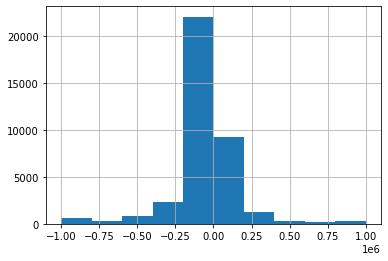

In [621]:
np.minimum(np.maximum(train["Sold Price"] - train["Listed Price"], -1e6), 1e6).hist()